In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


Using TensorFlow backend.


# Prepare Data from folders into a df

In [3]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


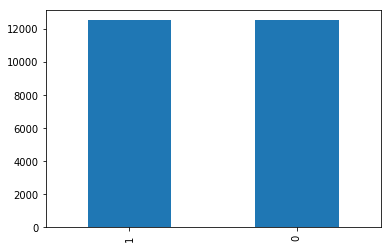

In [6]:
df['category'].value_counts().plot.bar()

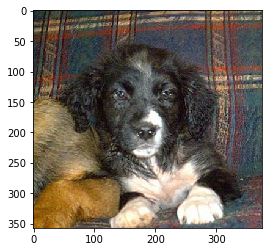

In [7]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Prepare data
    Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

### So we will convert 1 to dog and 0 to cat

In [8]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

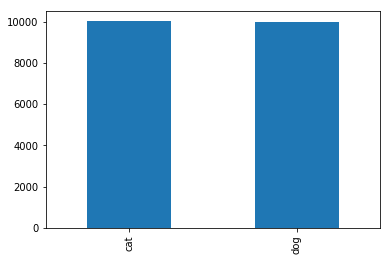

In [9]:
train_df['category'].value_counts().plot.bar()

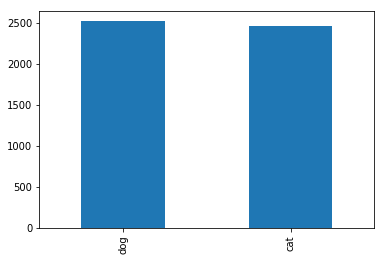

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training and Validation Generator


In [12]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Creating the model

## Input Layer: 
    It represent input image data. It will reshape image into single diminsion array. 
    Example your image is 64x64 = 4096, it will convert to (4096,1) array.

## Conv Layer: 
    This layer will extract features from image.
    
## Pooling Layer: 
    This layerreduce the spatial volume of input image after convolution.

## Fully Connected Layer: 
    It connect the network from a layer to another layer

## Output Layer: 
    It is the predicted values layer.

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

# Hyper parameters tuning

## Early Stop
### To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
## Learning Rate Reduction
### We will reduce the learning rate when then accuracy not increase for 2 steps

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


# Running the model

In [17]:
epochs=3 if FAST_RUN else 10

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 1888s 1s/step - loss: 0.7511 - acc: 0.6281 - val_loss: 0.5955 - val_acc: 0.6753
Epoch 2/3
1333/1333 [==============================] - 1781s 1s/step - loss: 0.5591 - acc: 0.7208 - val_loss: 0.5894 - val_acc: 0.7358
Epoch 3/3
1333/1333 [==============================] - 1759s 1s/step - loss: 0.5083 - acc: 0.7566 - val_loss: 0.5034 - val_acc: 0.7637


In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("animal_classification.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("animal_classification.h5")
print("Saved model to disk")

from keras.models import model_from_json
# load json and create model
json_file = open('animal_classification.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("animal_classification.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


# Visualise Training

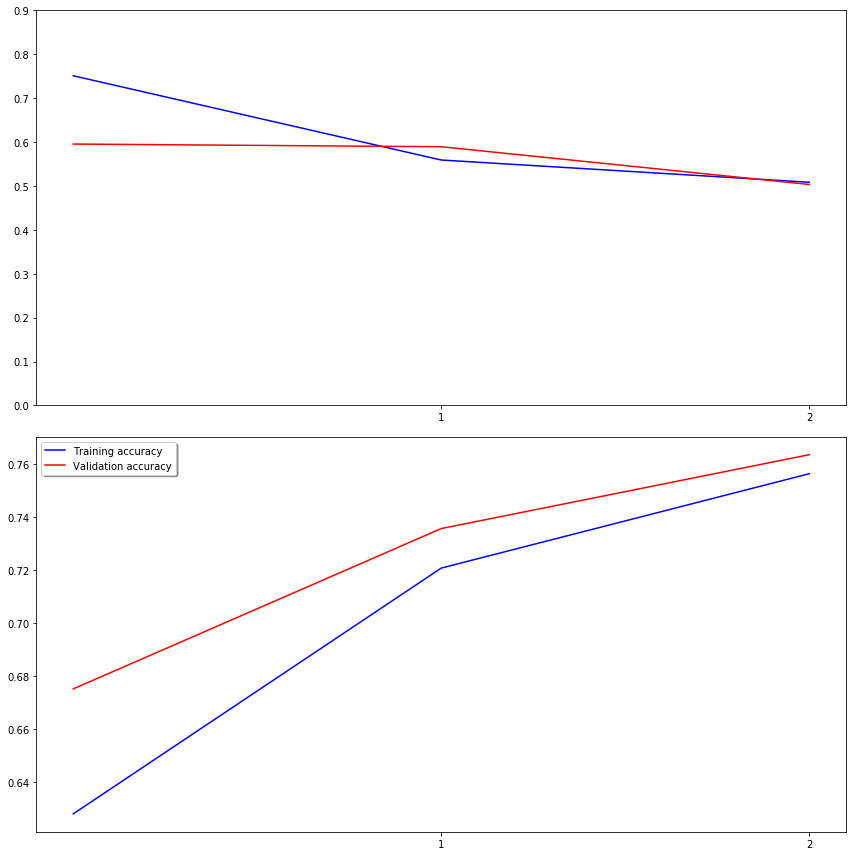

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [28]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)

12500


# Create Testing Generator

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


# Predicting on test data

In [22]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [23]:
#For categoral classication the prediction will come with probability of each category. 
#So we will pick the category that have the highest probability with numpy average max.

test_df['category'] = np.argmax(predict, axis=-1)

#We will convert the predict category back into our generator classes by using train_generator.class_indices.
#It is the classes that image generator map while converting data into computer vision.

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [24]:
# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

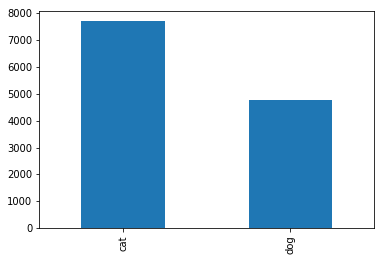

In [25]:
test_df['category'].value_counts().plot.bar()


# See predicted results with images

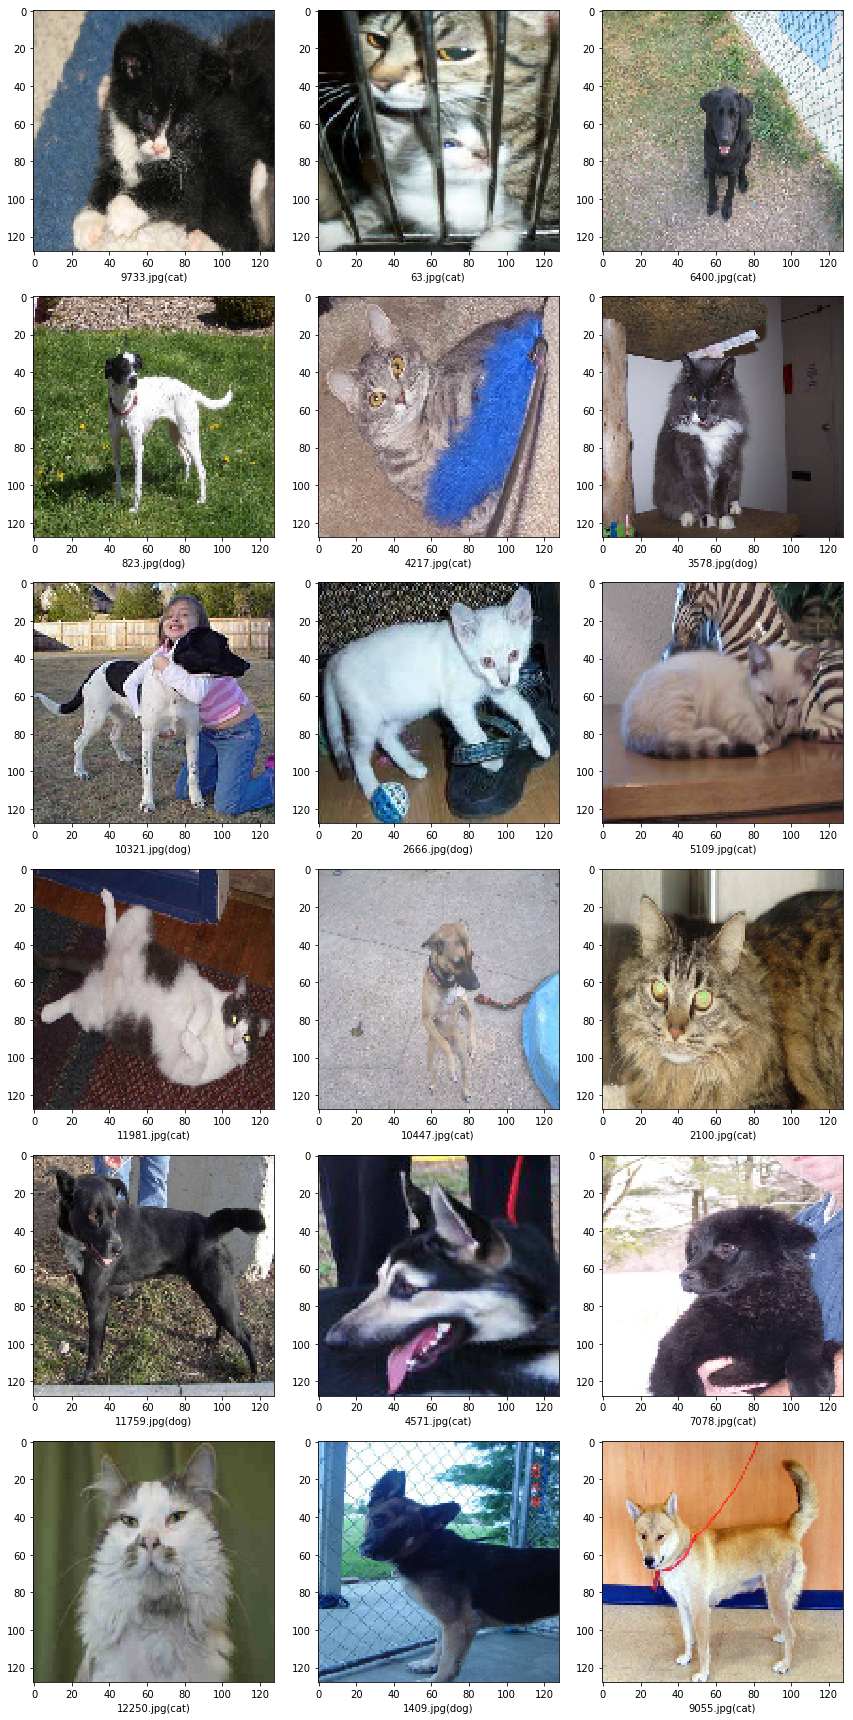

In [27]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Predicting on Validation data

In [31]:
samples = validate_df.shape[0]
print(samples)


5000


In [32]:
predict_on_validate = model.predict_generator(validation_generator, steps=np.ceil(samples/batch_size))

In [33]:
print(predict_on_validate)

[[0.3004052  0.69959486]
 [0.77339435 0.2266056 ]
 [0.76030046 0.2396995 ]
 ...
 [0.4640718  0.53592825]
 [0.8492454  0.15075456]
 [0.40074787 0.5992521 ]]


In [35]:
#For categoral classication the prediction will come with probability of each category. 
#So we will pick the category that have the highest probability with numpy average max.
#We will convert the predict category back into our generator classes by using train_generator.class_indices.
#It is the classes that image generator map while converting data into computer vision.


validate_df['predicted_category'] = np.argmax(predict_on_validate, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predicted_category'] = validate_df['predicted_category'].replace(label_map)

actual_class_validated = validate_df.category.tolist()
predicted_class_validated = validate_df.predicted_category.tolist()

# Plotting the confusion - matrix

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
cnf_matrix=confusion_matrix(actual_class_validated, predicted_class_validated)
print(cnf_matrix)

[[1489  983]
 [1569  959]]


In [40]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(len(classes))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1489  983]
 [1569  959]]
2


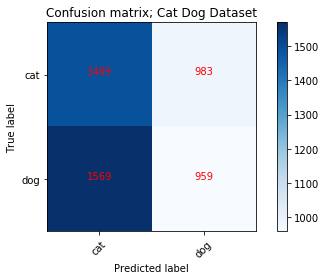

In [41]:
class_names =['cat','dog']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix; Cat Dog Dataset')
plt.show()

# Other different things that you can explore with image data
### RESIZING:
    img = cv2.resize(img,(48,48))
### BLURRING: 
    img = cv2.GaussianBlur(img, (3,3), 0)
### DIFFERENT FILTERS: 
    img = cv2.bilateralFilter(img, 5, 50, 50)
### BRIGHTNESS: 
    img = increase_brightness(img, value=30)
### GRAYSCALING: 
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Explore relating to model:
### 1. Try with and without hyperparameter tuning (Remove the callbacks that we added)
### 2. Vary epochs, batch size, learning rate
### 3. Vary number of Convolution layers, values of dropouts, number of node in each layer, activation function in each layers.